## Import Section

In [30]:
import copy
from IPython import display
import math
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import metrics
from sklearn import preprocessing, linear_model
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
from tensorflow.python.data import Dataset

import sys
sys.path.append('../')

from pygolfdata.data import shotlink

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

%matplotlib inline

## Read Data

Read 2016 Shot Link - Weather data combination and then looking at the sample data, the metadata info, and summary.

In [14]:
df_ori = shotlink.get_combined_data_from_file(
    '../../golf_course_project_data/test/combined_shots_and_weather_2016_2016.csv')
df_ori = df_ori.dropna(subset=['StrokesGainedBaseline'])

In [15]:
df_ori.head()

,TourCode,TourDescription,Year,TournamentNum,PlayerNum,CourseNum,PermanentTournamentNum,PlayerFirstName,PlayerLastName,Round,...,Humidity,Visibility,WindBearing,WindGust,WindSpeed,PrecipitationIntensity,PrecipitationType,CourseName_weather,WeatherDateAndHour,TimeDifference
0,R,PGA TOUR,2016,10,24912,552,464,Will,MacKenzie,1,...,0.8,9.7,274.0,nan,3.5,0.0,None,Silverado CC (North),2015-10-15 07:00:00,0 days 00:20:00.000000000
1,R,PGA TOUR,2016,10,28158,552,464,Steve,Marino,1,...,0.8,9.7,274.0,nan,3.5,0.0,None,Silverado CC (North),2015-10-15 07:00:00,0 days 00:21:00.000000000
2,R,PGA TOUR,2016,10,33419,552,464,Cameron,Tringale,1,...,0.8,9.7,274.0,nan,3.5,0.0,None,Silverado CC (North),2015-10-15 07:00:00,0 days 00:21:00.000000000
3,R,PGA TOUR,2016,10,26476,552,464,Chez,Reavie,1,...,0.8,9.7,274.0,nan,3.5,0.0,None,Silverado CC (North),2015-10-15 07:00:00,0 days 00:21:00.000000000
4,R,PGA TOUR,2016,10,35451,552,464,Scott,Pinckney,1,...,0.8,9.7,274.0,nan,3.5,0.0,None,Silverado CC (North),2015-10-15 07:00:00,0 days 00:22:00.000000000


In [16]:
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 998
Data columns (total 65 columns):
TourCode                   999 non-null category
TourDescription            999 non-null category
Year                       999 non-null uint16
TournamentNum              999 non-null uint16
PlayerNum                  999 non-null uint16
CourseNum                  999 non-null uint16
PermanentTournamentNum     999 non-null uint16
PlayerFirstName            999 non-null category
PlayerLastName             999 non-null category
Round                      999 non-null uint8
TournamentName             999 non-null category
CourseName_shots           999 non-null object
Hole                       999 non-null uint8
HoleScore                  999 non-null float32
ParValue                   999 non-null uint8
Yardage                    999 non-null uint16
Shot                       999 non-null uint8
ShotType                   999 non-null category
NumStrokes                 999 non-null 

In [17]:
df_ori.describe()

,Year,TournamentNum,PlayerNum,CourseNum,PermanentTournamentNum,Round,Hole,HoleScore,ParValue,Yardage,...,Hour,Latitude,Longitude,DegreesFahrenheit,Humidity,Visibility,WindBearing,WindGust,WindSpeed,PrecipitationIntensity
count,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,0.0,999.0,999.0
mean,2016.0,10.0,28295.2,552.0,464.0,1.0,7.6,4.0,3.9,391.7,...,8.5,38.3,-122.3,64.0,0.7,9.4,282.1,nan,5.9,0.0
std,0.0,0.0,6085.8,0.0,0.0,0.0,4.9,0.9,0.6,106.4,...,0.5,0.0,0.0,2.1,0.1,0.1,2.2,nan,0.4,0.0
min,2016.0,10.0,2206.0,552.0,464.0,1.0,1.0,2.0,3.0,182.0,...,7.0,38.3,-122.3,61.7,0.7,9.3,274.0,nan,3.5,0.0
25%,2016.0,10.0,24781.0,552.0,464.0,1.0,3.0,4.0,4.0,391.0,...,8.0,38.3,-122.3,61.7,0.7,9.3,280.0,nan,5.6,0.0
50%,2016.0,10.0,28237.0,552.0,464.0,1.0,7.0,4.0,4.0,424.0,...,9.0,38.3,-122.3,65.9,0.7,9.3,284.0,nan,6.2,0.0
75%,2016.0,10.0,33399.0,552.0,464.0,1.0,12.0,4.0,4.0,458.0,...,9.0,38.3,-122.3,65.9,0.8,9.6,284.0,nan,6.2,0.0
max,2016.0,10.0,47133.0,552.0,464.0,1.0,17.0,7.0,5.0,571.0,...,9.0,38.3,-122.3,65.9,0.8,9.7,284.0,nan,6.2,0.0


## Exploratory Data Analysis

The goal of this project is to explore the effects of weather on Strokes Gained, a PGA metric available in the ShotLink dataset. StrokesGained aims to quantify the value of each shot taken by a golfer by comparing it so shots taken from the similar areas and distances. A more in depth explanation is available [here](https://www.pgatour.com/news/2016/05/31/strokes-gained-defined.html). 

Before doing any predictive modeling, we'll first do some exploratory analysis to identify key features. Initially, we'll see how Strokes Gained varies with:
- DegreesFahrenheit
- Humidity
- Visibility
- WindSpeed
- PrecipitationIntensity
- PrecipitationType

It's important to note that these factors might affect shot types in different ways. For example, wind might not affect putts in the same way as drives. So we'll often use StrokesGainedCategory to differentiate shot types. 

In [24]:
#Scatter plot function

def plot_strokes_gained_scatter(df, x_var, by_cat = True):
    '''Creates a scatter plot of StrokesGained vs chosen variable. 
    
    Arguments:
        df (str): input dataframe
        x_var (str): variable to plot against
        by_cat (bool): whether or not to plot by shot category, default = True
        
    Returns:
        Scatter plot, ensure to use '%matplotlib inline' to have plot show
    '''
    if by_cat == True:
        sns.lmplot(x = x_var, y = 'StrokesGainedBaseline', col = 'StrokesGainedCategory', data = df,
          fit_reg = False, col_order = ['Off the Tee','Approach to the Green','Around the Green','Putting'],
                  col_wrap = 2,scatter_kws = {'alpha': 0.35})
    else:
        sns.lmplot(x = x_var, y = 'StrokesGainedBaseline', data = df, fit_reg = False,
                  col_order = ['Off the Tee','Approach to the Green','Around the Green','Putting'],
                  col_wrap = 2, scatter_kws = {'alpha': 0.35})

#### StrokesGained vs DegreesFahrenheit

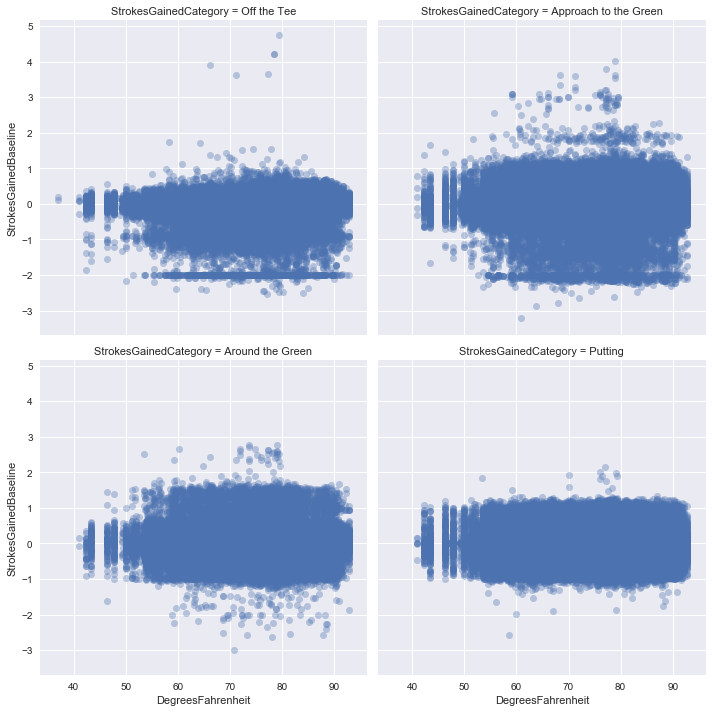

In [25]:
plot_strokes_gained_scatter(df_ori, 'DegreesFahrenheit')

We see that the variance in Strokes Gained tends to narrow at colder temperatures for all categories except putting. However, this could be the effect of not having as much data for colder weather. It also appears that there are less extreme Strokes Gained values at hotter temperatures, though again this could be the effect of smaller sample sizes. 

#### StrokesGained vs Humidity

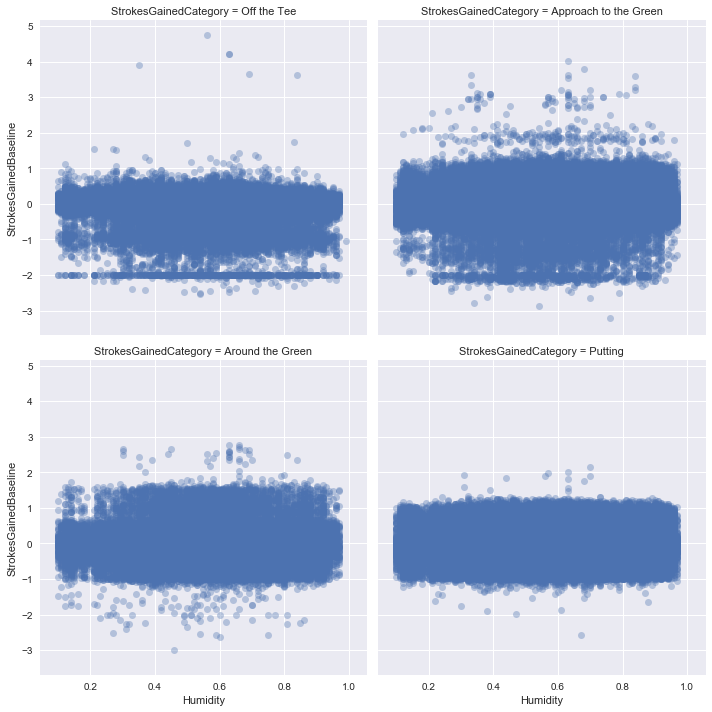

In [26]:
plot_strokes_gained_scatter(df_ori, 'Humidity')

There doesn't appear to be any major relationship between Strokes Gained and humidity. It looks like there may be a slight negative correlation for shots off the tee and a slight positive correlation for approaches to the green. We'll explore correlation coefficients later in the analysis. 

#### StrokesGained vs Visibility

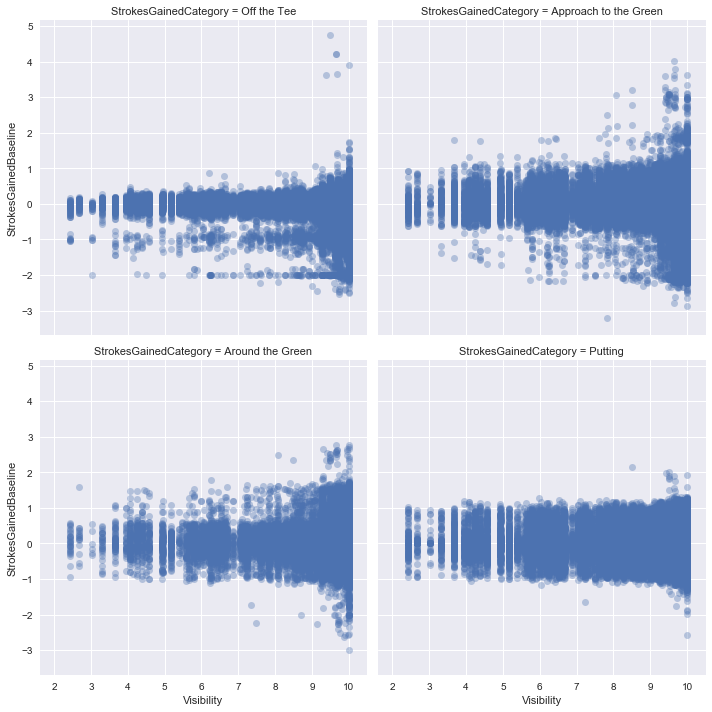

In [27]:
plot_strokes_gained_scatter(df_ori, 'Visibility')

For all shot categories we see a trend of narrowing variance in Strokes Gained as visibilty decreases. One might expect a fairly linear negative correlation between visibility and Strokes Gained, since it would seem that poor visibility would lead to bad shots. Perhaps this is another case of small sample sizes, or it's possible that in poor visibility golfers take less risks, resulting in more 'average' shots. 

#### StrokesGained vs WindSpeed

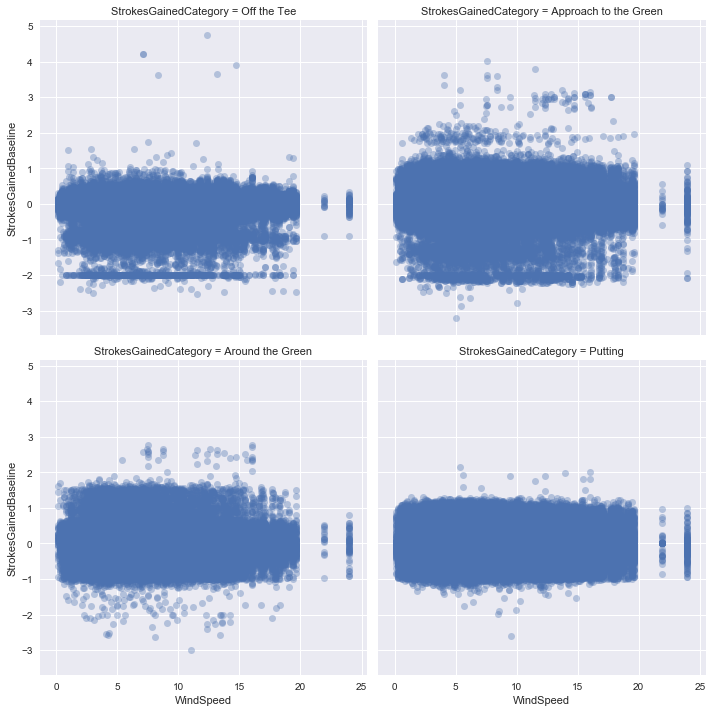

In [28]:
plot_strokes_gained_scatter(df_ori, 'WindSpeed')

Surprisingly, wind speed also appears to have very little correlation with Strokes Gained. However, it's important to note that we are not capturing any wind direction information here. While the dataset contains a 'WindBearing' column that provides the wind direction, it is not relative to the direction of the shot. One could assume that heavy crosswinds or headwinds would lead to lower Strokes Gained, while tail winds would lead to an increase in Strokes Gained. 

#### StrokesGained vs PrecipitationIntensity

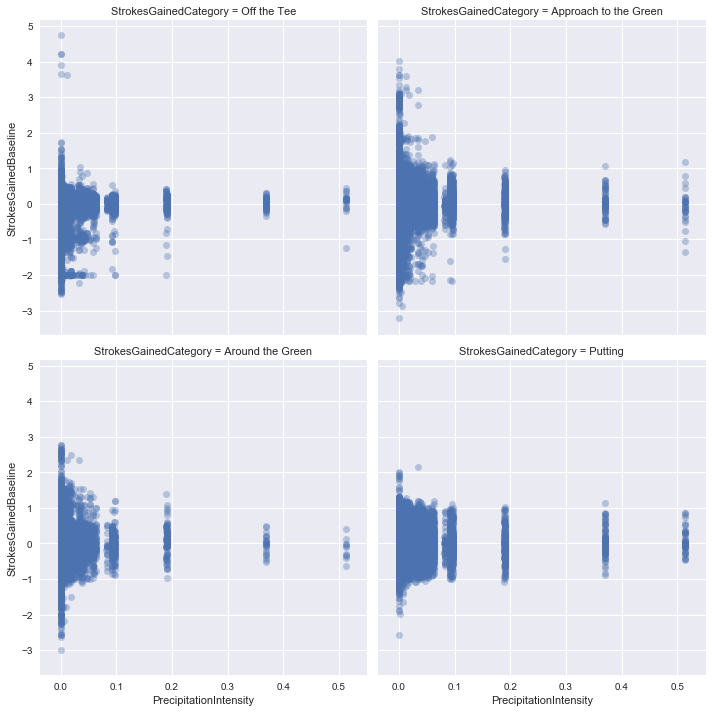

In [29]:
plot_strokes_gained_scatter(df_ori, 'PrecipitationIntensity')

The immediate takeaway from this plot is that the PGA does not like to hold events in any sort of rain. The sample sizes for higher precipitation intensities are very small. However, we see a similar trend to that of visibility. In general, as precipitation intensity increases, the variance in Strokes Gained decreases. 

#### Correlation Coefficients

In [64]:
heatmap_df = df_ori[['StrokesGainedBaseline','StrokesGainedCategory','DegreesFahrenheit','Humidity','Visibility',
                     'WindSpeed','PrecipitationIntensity']]

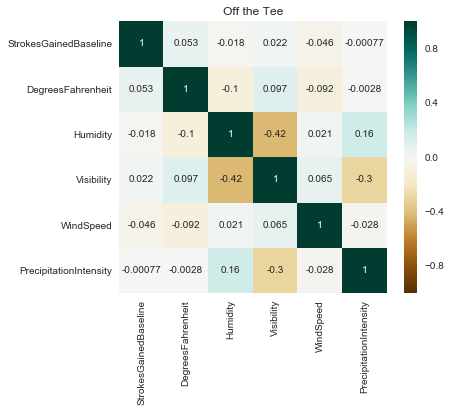

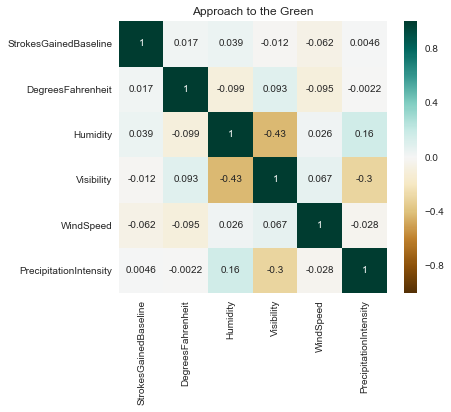

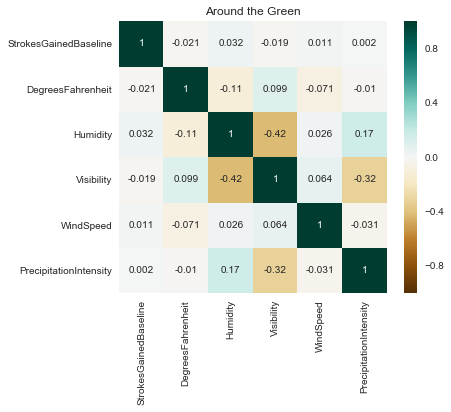

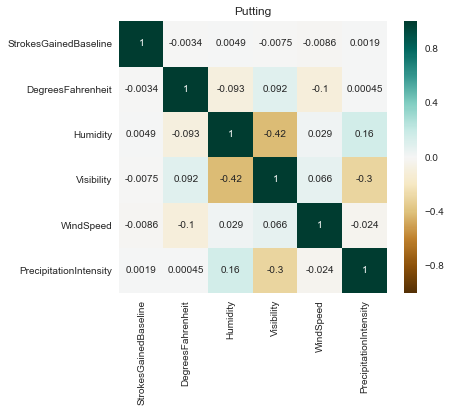

In [65]:
categories = ['Off the Tee','Approach to the Green','Around the Green','Putting']

for cat in categories:
    plt.subplots(figsize=(6,5))
    sns.heatmap(heatmap_df[heatmap_df['StrokesGainedCategory'] == cat].corr(), cmap = 'BrBG', annot = True)
    plt.title(cat)

#### StrokesGained vs PrecipitationType

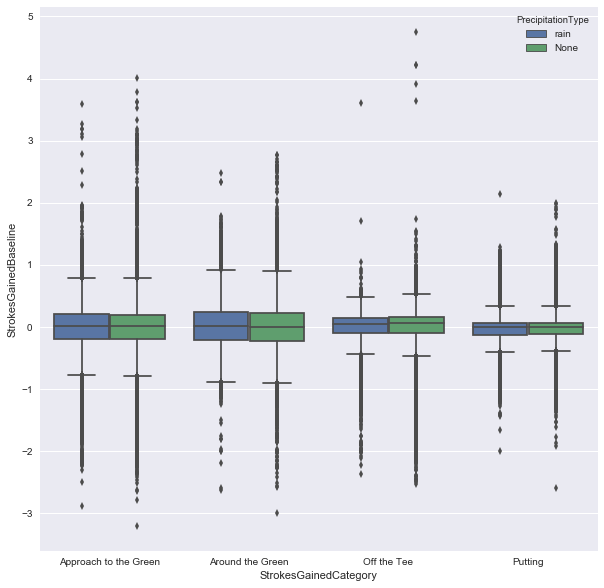

In [66]:
plt.subplots(figsize=(10,10))
sns.boxplot(x = 'StrokesGainedCategory', y = 'StrokesGainedBaseline', hue = 'PrecipitationType', data = df_ori)

In [67]:
gb_cat_precip = df_ori.groupby(['StrokesGainedCategory','PrecipitationType']).mean()

In [68]:
pd.DataFrame(gb_cat_precip['StrokesGainedBaseline'])

StrokesGainedBaseline
StrokesGainedCategory PrecipitationType                       
Approach to the Green rain                                 0.0
                      None                                 0.0
Around the Green      rain                                 0.0
                      None                                 0.0
Off the Tee           rain                                -0.0
                      None                                 0.0
Putting               rain                                -0.0
                      None                                -0.0

#### Player Performance by Precipitation Type

In [69]:
gb_player_precip = df_ori.groupby(['PlayerName','PrecipitationType']).mean()

In [70]:
gb_player_precip_sg = pd.DataFrame(gb_player_precip['StrokesGainedBaseline'])

In [71]:
gb_player_precip_sg.head()

StrokesGainedBaseline
PlayerName     PrecipitationType                       
Aaron Baddeley rain                                 0.0
               None                                 0.0
Aaron Wise     rain                                 0.0
               None                                 0.1
Abraham Ancer  rain                                -0.0

In [72]:
#Get sample sizes for each player

for i in gb_player_precip_sg.index.tolist():
    player_name = i[0]
    cat = i[1]
    shot_types = pd.DataFrame(df_ori[df_ori['PlayerName'] == player_name]['PrecipitationType'].value_counts())
    gb_player_precip_sg.loc[i, 'num_shots'] = shot_types.loc[cat]['PrecipitationType']

In [73]:
gb_player_precip_sg.head(10)

StrokesGainedBaseline  num_shots
PlayerName     PrecipitationType                                  
Aaron Baddeley rain                                 0.0     1252.0
               None                                 0.0     5097.0
Aaron Wise     rain                                 0.0      127.0
               None                                 0.1      145.0
Abraham Ancer  rain                                -0.0      624.0
               None                                -0.0     2832.0
Adam Cornelson rain                                 nan        0.0
               None                                -0.0      148.0
Adam Hadwin    rain                                 0.0     1000.0
               None                                 0.0     5596.0

In [74]:
#Filter out num_shots < 100

gb_player_precip_sg = gb_player_precip_sg[gb_player_precip_sg['num_shots'] >= 100]

In [75]:
#Sort by StrokesGained

gb_player_precip_sg.sort_values('StrokesGainedBaseline', ascending = False)

,,StrokesGainedBaseline,num_shots
PlayerName,PrecipitationType,,
Aaron Wise,None,0.1,145.0
Hideki Matsuyama,rain,0.1,560.0
Wesley Bryan,rain,0.1,210.0
Ryan Armour,None,0.1,184.0
Jon Rahm,rain,0.0,305.0
...,...,...,...
Hugo Bernard,None,-0.1,157.0
Mark Blakefield,None,-0.1,157.0
James Morrison,None,-0.1,110.0


## Data cleaning and preparation

First, we deep copy the original dataframe to another dataframe for cleaning and processing purpose.

We perform a selection of columns suitable for analysis for different kinds of linear regression. Initially we will attempt OLS and Ridge regression and assess the results. From the scatter plots before, it appeared humidity may have been a factor in StrokesGained, so we will definitely include that and other measures that do not vary depending on the direction of the shot taken.

In [6]:
df = df_ori.copy(deep=True)

Drop columns which have more than 1% of their values missing, then drop rows with missing values.

In [7]:
# Drop columns which have more than 1% of their values missing
# Then drop rows missing values

pct_threshold = 0.01
no = df.apply(lambda x: x.isna().sum() / df.shape[0])
drop_these_lame_columns = no[no >= pct_threshold].index

dnew = df.drop(columns=drop_these_lame_columns)

#dnew = dnew.dropna(axis=0, how='any')

In [8]:
dnew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1141966 entries, 0 to 1141965
Data columns (total 52 columns):
TourCode                   1141966 non-null object
TourDescription            1141966 non-null object
Year                       1141966 non-null int64
TournamentNum              1141966 non-null int64
PlayerNum                  1141966 non-null int64
CourseNum                  1141966 non-null int64
PermanentTournamentNum     1141966 non-null int64
PlayerFirstName            1141966 non-null object
PlayerLastName             1141966 non-null object
Round                      1141966 non-null int64
TournamentName             1141966 non-null object
CourseName_shots           1141966 non-null object
Hole                       1141966 non-null int64
HoleScore                  1141601 non-null float64
ParValue                   1141966 non-null int64
Yardage                    1141966 non-null int64
Shot                       1141966 non-null int64
ShotType                   11

In [9]:
dnew = df.dropna(axis=1, how='any')
dnew.columns

Index(['TourCode', 'TourDescription', 'Year', 'TournamentNum', 'PlayerNum',
       'CourseNum', 'PermanentTournamentNum', 'PlayerFirstName',
       'PlayerLastName', 'Round', 'TournamentName', 'CourseName_shots', 'Hole',
       'ParValue', 'Yardage', 'Shot', 'ShotType', 'NumStrokes', 'Distance',
       'DistanceToPin', 'InTheHoleFlag', 'AroundTheGreenFlag',
       'DistanceToHoleAfterShot', 'Time', 'XCoordinate', 'YCoordinate',
       'ZCoordinate', 'DistanceFromCenter', 'DistanceFromEdge', 'Date_shots',
       'StrokesGainedBaseline', 'RecoveryShot', 'ShotDateAndTime',
       'PlayerName', 'Date_weather', 'Hour', 'Latitude', 'Longitude',
       'Summary', 'DegreesFahrenheit', 'Humidity', 'Visibility',
       'PrecipitationIntensity', 'CourseName_weather', 'WeatherDateAndHour',
       'TimeDifference'],
      dtype='object')

In [10]:
col_for_model = ['Summary', 'DegreesFahrenheit', 'Humidity', 'Visibility', 'PrecipitationIntensity', 'StrokesGainedBaseline']
df = dnew[col_for_model]
df = df.dropna(axis=0, how='any')
df.describe()

,DegreesFahrenheit,Humidity,Visibility,PrecipitationIntensity,StrokesGainedBaseline
count,1141966.0,1141966.0,1141966.0,1141966.0,1141966.0
mean,74.1,0.6,9.6,0.0,0.0
std,9.0,0.2,1.0,0.0,0.3
min,37.0,0.1,2.1,0.0,-3.2
25%,67.1,0.5,9.6,0.0,-0.1
50%,75.9,0.6,9.9,0.0,0.0
75%,80.8,0.7,10.0,0.0,0.1
max,92.8,1.0,10.0,0.5,4.8


### Split data into Training & Test

Let us prepare for regression model testing and training. We notice that we have a summary column with a finite number of distinct values.

We binarize those to get several more features to train on, and split by 80/20 for training and test.

In [18]:
response = 'StrokesGainedBaseline'
X = copy.deepcopy(df)
y = X[response]
X = X.drop(columns=response)
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scalerX = preprocessing.StandardScaler().fit(X_train)
scalerY = preprocessing.StandardScaler().fit(y_train.reshape(-1, 1))

X_train_scaled = scalerX.transform(X_train)
X_test_scaled = scalerX.transform(X_test)
y_train_scaled = scalerY.transform(y_train.reshape(-1, 1))
y_test_scaled = scalerY.transform(y_test.reshape(-1, 1))

/Users/radji/miniconda3/envs/dsenv/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/Users/radji/miniconda3/envs/dsenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':
/Users/radji/miniconda3/envs/dsenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  del sys.path[0]


## Linear Regression Using Scikit Learn

First up is OLS regression. With a single training set, single run we achieve a Mean Squared Error of 0.99 (very, very bad), and a $R^2$ score of zero. 

In [12]:
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train_scaled, y_train_scaled)

# Make predictions using the testing set
y_pred = regr.predict(X_test_scaled)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: {0:.2f}".format(mean_squared_error(y_test_scaled, y_pred)))
# Explained variance score: 1 is perfect prediction
print('Variance score: {0:.2f}'.format(r2_score(y_test_scaled, y_pred)))

Coefficients: 
 [[ 8.01602370e-03  1.47638421e-02  2.60464816e-03 -2.11117837e-03
   3.38091632e+11  8.20789073e+10  4.76830308e+10  2.05297441e+11
   1.14426370e+12  4.62675807e+10  5.19575675e+11  2.12870914e+11
   6.07266323e+10  3.49855090e+11  1.74849879e+11  8.08192974e+10
   3.12875884e+11  2.20283461e+11  9.84117292e+11  1.93795264e+11
   1.59351611e+11]]
Mean squared error: 0.99
Variance score: 0.00


### Ridge regression

Undeterred we move forward with Ridge regression, using K-fold validation with 10 splits and 10 alphas.

In [13]:
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV

kf = KFold(n_splits=10, shuffle=True)
alphas = (0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1)
rcv = RidgeCV(alphas=alphas, cv=kf)

rcv.fit(X_train_scaled, y_train_scaled)

RidgeCV(alphas=(0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1),
    cv=KFold(n_splits=10, random_state=None, shuffle=True),
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [14]:
y_pred = rcv.predict(X_test_scaled)

# The coefficients
print('Coefficients: \n', rcv.coef_)
# The mean squared error
print("Mean squared error: {0:.2f}".format(mean_squared_error(y_test_scaled, y_pred)))
# Explained variance score: 1 is perfect prediction
print('Variance score: {0:.2f}'.format(r2_score(y_test_scaled, y_pred)))

Coefficients: 
 [[ 0.00842054  0.0156793   0.00293933 -0.00310603 -0.00566888 -0.00120694
   0.00013321 -0.00650783  0.00016025  0.00343741  0.00012578 -0.00118315
   0.00170048  0.00164353 -0.0016751   0.0002741  -0.00131867 -0.00166654
   0.00297598  0.00172717  0.0018713 ]]
Mean squared error: 0.99
Variance score: 0.00


Ridge regression, while it achieved more stable coefficients acrosss multiple attempts, still was not able to find a good linear model. MSE continues to be 0.99 and $R^2$ is still zero. 

In [15]:
type(y_test_scaled)
y_pred

array([[-0.01582718],
       [-0.01173705],
       [ 0.00029096],
       ...,
       [-0.00272634],
       [ 0.01141256],
       [ 0.00800229]])

In [16]:
y_test_scaled

array([[ 0.28515591],
       [ 0.48037544],
       [-0.26849948],
       ...,
       [-0.82215486],
       [-0.48292093],
       [-0.00607322]])

## 2nd Attempt Using More Features with TensorFlow
As part of the cleaning the data, we lose some interesting features because those have too many Nan values. If we include those features, we might get a better Linear Regression model. We also convert `PrecipitationType` feature to 1 for rainy day and 0 for non-rainy day, and we call the new column `Rain`.

In [19]:
df = df_ori.copy(deep=True)

In [20]:
col_for_model = ['WindSpeed', 'StrokesGainedCategory', 'PrecipitationType', 
                 'Summary', 'DegreesFahrenheit', 'Humidity', 'Visibility', 
                 'PrecipitationIntensity', 'StrokesGainedBaseline']
df = df[col_for_model]
df['Rain'] = np.where(df['PrecipitationType']=='rain', 1, 0)
df = df.drop(columns='PrecipitationType')
df = df.dropna(axis=0, how='any')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 990 entries, 0 to 998
Data columns (total 9 columns):
WindSpeed                 990 non-null float32
StrokesGainedCategory     990 non-null category
Summary                   990 non-null category
DegreesFahrenheit         990 non-null float32
Humidity                  990 non-null float32
Visibility                990 non-null float32
PrecipitationIntensity    990 non-null float32
StrokesGainedBaseline     990 non-null float32
Rain                      990 non-null int64
dtypes: category(2), float32(6), int64(1)
memory usage: 40.8 KB


### Split data into Training & Test
In addition to splitting the data into training-test and standardizing both sets, we keep the train and test in form of pandas dataframe since TensorFlow accepts pandas dataframes format.

In [21]:
response = 'StrokesGainedBaseline'
X = df.copy(deep=True)
y = X[response]
X = X.drop(columns=response)
X = pd.get_dummies(X)
X.columns = X.columns.str.replace('\s+','_')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scalerX = preprocessing.StandardScaler().fit(X_train)
scalerY = preprocessing.StandardScaler().fit(y_train.values.reshape(-1, 1))

X_train_scaled = pd.DataFrame(scalerX.transform(X_train))
X_test_scaled = pd.DataFrame(scalerX.transform(X_test))
y_train_scaled = pd.DataFrame(scalerY.transform(y_train.values.reshape(-1, 1)))[0]
y_test_scaled = pd.DataFrame(scalerY.transform(y_test.values.reshape(-1, 1)))[0]

X_train_scaled.columns = X.columns
X_test_scaled.columns = X.columns
y_train_scaled.rename(y.name)
y_test_scaled.rename(y.name)

0     -1.7
1     -1.6
2     -0.0
3      2.4
4     -0.5
      ... 
193    0.6
194    0.2
195   -0.0
196   -0.0
197    0.3
Name: StrokesGainedBaseline, Length: 198, dtype: float32

Instead of using ScikitLearn package, we are using TensorFlow's `LinearRegressor`. This model is trained using the `GradientDescentOptimizer`, which implements Mini-Batch Stochastic Gradient Descent (SGD).

### Define the Input Function
An input function is required to instruct TensorFLow how to preprocess the data, including converting the pandas feature into a dict of NumPy, then constructing a dataset object from our data before breaking it down into batches.

In [26]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas Series of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [27]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

### Train the Model
call `train` function in the `LinearRegressor` object to train the model. We'll wrap `my_input_fn` in a lambda so we can pass in `feature` and `target` as arguments.

In [28]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing selected columns from
      `combined_shotlink_weather_data` to use for training.
    training_targets: A `DataFrame` containing exactly one column from
      `combined_shotlink_weather_data` to use as target for training.
    validation_examples: A `DataFrame` containing selected columns from
      `combined_shotlink_weather_data` to use for validation/test.
    validation_targets: A `DataFrame` containing selected columns from
      `combined_shotlink_weather_data` to use for validation/test.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets, 
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets, 
      num_epochs=1, 
      shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, validation_targets, 
      num_epochs=1, 
      shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("{0}: {1:.2f}".format(period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="test")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
0: 1.00
1: 1.00
2: 1.00
3: 1.00
4: 1.00
5: 1.00
6: 1.00
7: 1.00
8: 1.00
9: 1.00
Model training finished.


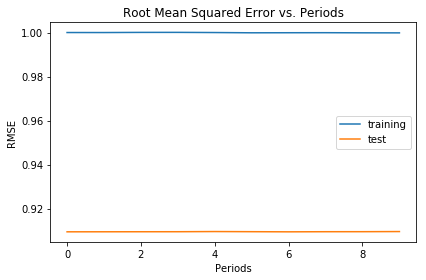

In [32]:
linear_regressor = train_model(
    learning_rate=0.0001,
    steps=50,
    batch_size=5,
    training_examples=X_train_scaled,
    training_targets=y_train_scaled,
    validation_examples=X_test_scaled,
    validation_targets=y_test_scaled)

# linear_regressor = train_model(
#     learning_rate=0.0001,
#     steps=50,
#     batch_size=5,
#     training_examples=X_train,
#     training_targets=y_train,
#     validation_examples=X_test,
#     validation_targets=y_test)

### Validate with Test Data
We'll calculate Mean Squared Error from the training data

In [35]:
predict_test_input_fn = lambda: my_input_fn(
      X_test_scaled, 
      y_test_scaled, 
      num_epochs=1, 
      shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

mean_squared_error = metrics.mean_squared_error(test_predictions, y_test_scaled)
root_mean_squared_error = math.sqrt(mean_squared_error)

print("MSE (on test data): {0:.2f}".format(mean_squared_error))
print("RMSE (on test data): {0:.2f}".format(root_mean_squared_error))

MSE (on test data): 0.83
RMSE (on test data): 0.91


Let's compare the MSE with the label(`ShotGainedBaseline`)'s range, wich is its max - its min.

In [38]:
label_range = y_test_scaled.max() - y_test_scaled.min()
print('StrokesGainedBaseline standardized test range: {}'.format(label_range))

StrokesGainedBaseline standardized test range: 8.600632667541504


In [39]:
print('StrokesGainedBaseline standardized test variance: {}'.format(y_test_scaled.var()))

StrokesGainedBaseline standardized test variance: 0.8289118409156799


The Root Mean Squared Error of the prediction is close to the test variance, which is discouraging but expected since the response, `StrokesGainedBaseline`, variance is very small. 

## Analysis
By looking at the Mean Squared Error (and Root Mean Squared Error), this Linear Regression does not seem to perform well on this specific set of features and label. The visualization of each potential feature confirms that there is little individua A different Machine Learning model might fare a little better, but I suspect the `StrokesGainedBaseline` just does not respond well to the selected weather features, such as `WindSpeed`, `Precipitation`, or `DegreesFrahrenheit`.  